## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv("/Users/kamininayyar/Downloads/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Exploration

In [4]:
df.shape

(404290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# Checking the null values
nul_rows= df[df.isnull().any(1)]
print(nul_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [8]:
# let's fill these values with ' ' and then check again
df = df.fillna(' ')
nul_rows= df[df.isnull().any(1)]
print(nul_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [9]:
df.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

In [10]:
total_qids= pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
total_qids.head(2).append(total_qids.tail(2))


/var/folders/m1/0br6blcd2dn3_xv2mdc77vc80000gn/T/ipykernel_75337/4220272211.py:2: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0              1
1              3
808578    537931
808579    537933
dtype: int64

In [11]:
import numpy as np
uniq_qids = len(np.unique(total_qids))
uniq_qids
# Total Unique Questions

537933

In [12]:
# Now Let's check no. of repeated Questions
repeated_ques = np.sum(total_qids.value_counts() >1)
max_qid_count = np.max(total_qids.value_counts())
print(repeated_ques)
print(max_qid_count)

111780
157


Maximum number of times a single question is repeated: 157



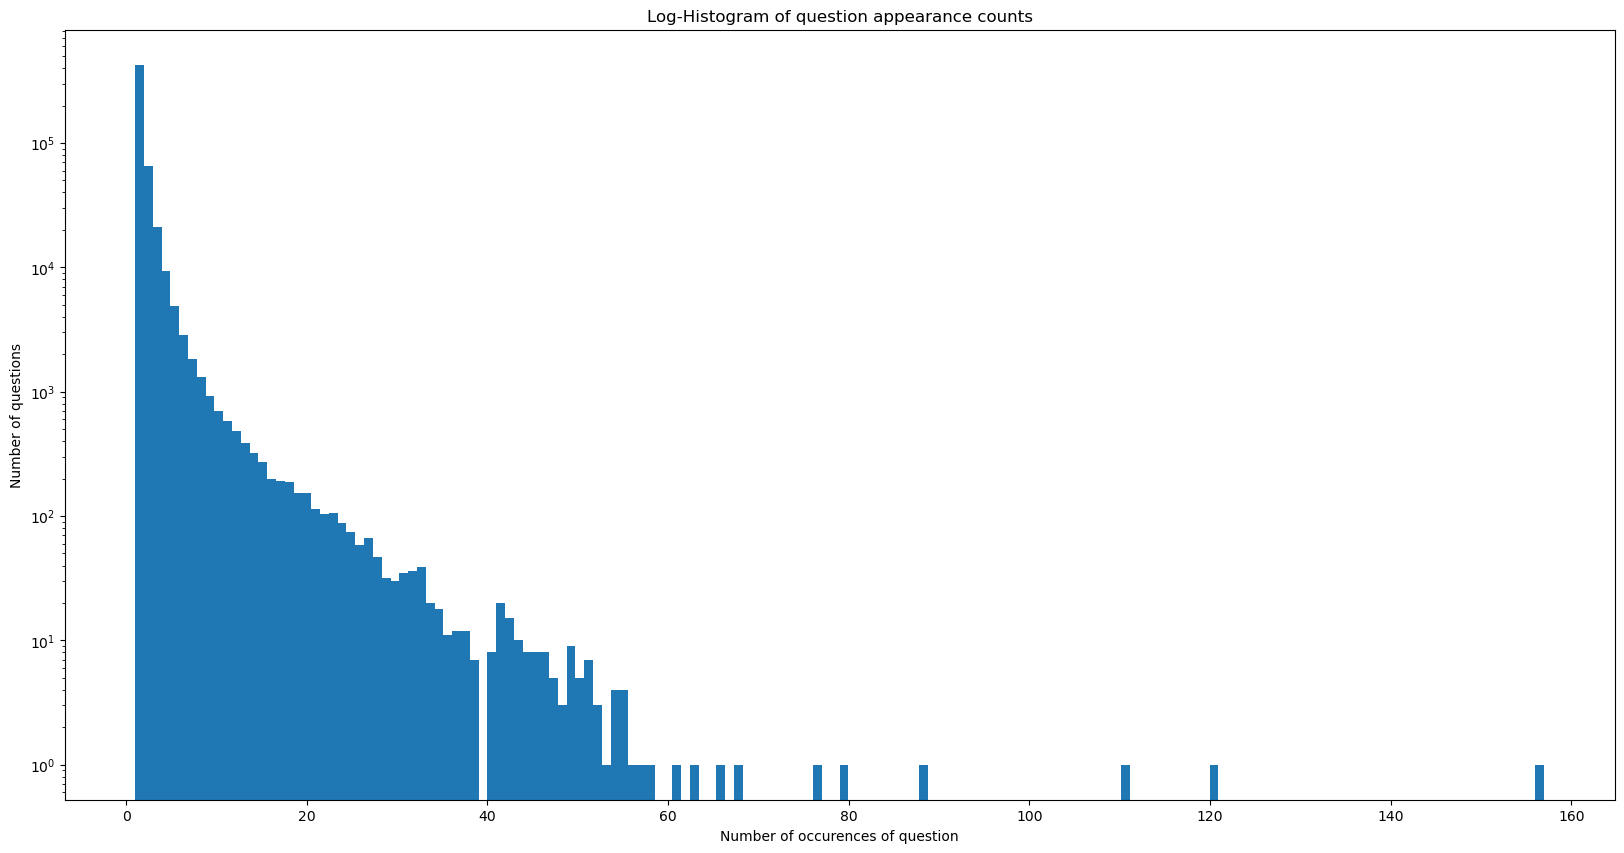

In [13]:
# How many times each question is repeated
plt.figure(figsize=(20, 10))

plt.hist(total_qids.value_counts(), bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(total_qids.value_counts())))

In [14]:
# stripping the columns
if os.path.isfile('df_quora_duplicates_train.csv'):
    df = pd.read_csv('df_quora_duplicates_train.csv',encoding='latin-1')
else:
    df["count_qid1"]= df.groupby("qid1")["qid1"].transform("count")
    df["count_qid2"]= df.groupby("qid2")["qid2"].transform("count")

    df["q1len"]= df["question1"].str.len()
    df["q2len"]= df["question2"].str.len()

    df["q1_nwords"]= df["question1"].apply(lambda row: len(row.split(" ")))
    df["q2_nwords"]= df["question2"].apply(lambda row: len(row.split(" ")))

    def normalized_common_words(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)
    df['common_words'] = df.apply(normalized_common_words, axis=1)

    def normalized_word_Total(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * (len(w1) + len(w2))
    df['total_words'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq.q1+q2'] = df['count_qid1']+df['count_qid2']
    df['freq.q1-q2'] = abs(df['count_qid1']-df['count_qid2'])

    df.to_csv("df_quora_duplicates_train.csv", index=False)
    
df.head(2)


,id,qid1,qid2,question1,question2,is_duplicate,count_qid1,count_qid2,q1len,q2len,q1_nwords,q2_nwords,common_words,total_words,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [15]:
# punctuation included in the default list:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
df['questions'] = (df['question1']) + (df['question2'])

In [17]:
# Define a function to remove punctuation in our messages

def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text
df['text_clean'] = df['questions'].apply(lambda x: remove_punct(x))
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,count_qid1,count_qid2,q1len,q2len,q1_nwords,q2_nwords,common_words,total_words,word_share,freq_q1+q2,freq_q1-q2,questions,text_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...


In [18]:
#import regular expression
import re

def tokenize(text):
    tokens = text.split()
    return tokens

df['text_tokenized'] = df['text_clean'].apply(lambda x: tokenize(x.lower()))

df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,count_qid1,count_qid2,q1len,q2len,q1_nwords,q2_nwords,common_words,total_words,word_share,freq_q1+q2,freq_q1-q2,questions,text_clean,text_tokenized
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv..."


In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kamininayyar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
ENGstopwords = stopwords.words('english')
ENGstopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

df['text_nostop'] = df['text_tokenized'].apply(lambda x: remove_stopwords(x))

df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,count_qid1,count_qid2,q1len,q2len,...,q2_nwords,common_words,total_words,word_share,freq_q1+q2,freq_q1-q2,questions,text_clean,text_tokenized,text_nostop
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, ind..."


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [21]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
from tqdm import tqdm
import spacy

In [22]:
from sklearn.feature_extraction.text import CountVectorizer #for BoW
vect = CountVectorizer()

# Convenience function
# This function will apply a vectorizer to a series of text
# Will return a dataframe with the results of the vectorizer.
def create_doc_term_matrix(text,vectorizer):
    doc_term_matrix = vectorizer.fit_transform(text)
    return pd.DataFrame(doc_term_matrix.toarray(), columns = vectorizer.get_feature_names())

In [23]:
vectorizer_input = df['text_nostop'].apply(lambda x: " ".join(x) )
vectorizer_input

0         step step guide invest share market indiawhat ...
1         story kohinoor kohinoor diamondwhat would happ...
2         increase speed internet connection using vpnho...
3         mentally lonely solve itfind remainder math232...
4         one dissolve water quikly sugar salt methane c...
                                ...                        
404285    many keywords racket programming language late...
404286                 believe life deathis true life death
404287                                   one coinwhats coin
404288    approx annual cost living studying uic chicago...
404289                  like sex cousinwhat like sex cousin
Name: text_nostop, Length: 404290, dtype: object

In [24]:
X = vect.fit_transform(vectorizer_input)
type(X)

scipy.sparse._csr.csr_matrix

In [25]:
X.shape

(404290, 203135)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc